In [8]:
# %pip install matplotlib numpy opencv-python Pillow moviepy

In [9]:
# %pip freeze

In [10]:
#Importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
import glob
from moviepy.editor import VideoFileClip

%matplotlib inline

In [11]:
def list_images(images, cols = 2, rows = 5, cmap=None):
    plt.figure(figsize=(10, 11))
    for i, image in enumerate(images):
        plt.subplot(rows, cols, i+1)
        cmap = 'gray' if len(image.shape) == 2 else cmap
        plt.imshow(image, cmap = cmap)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()

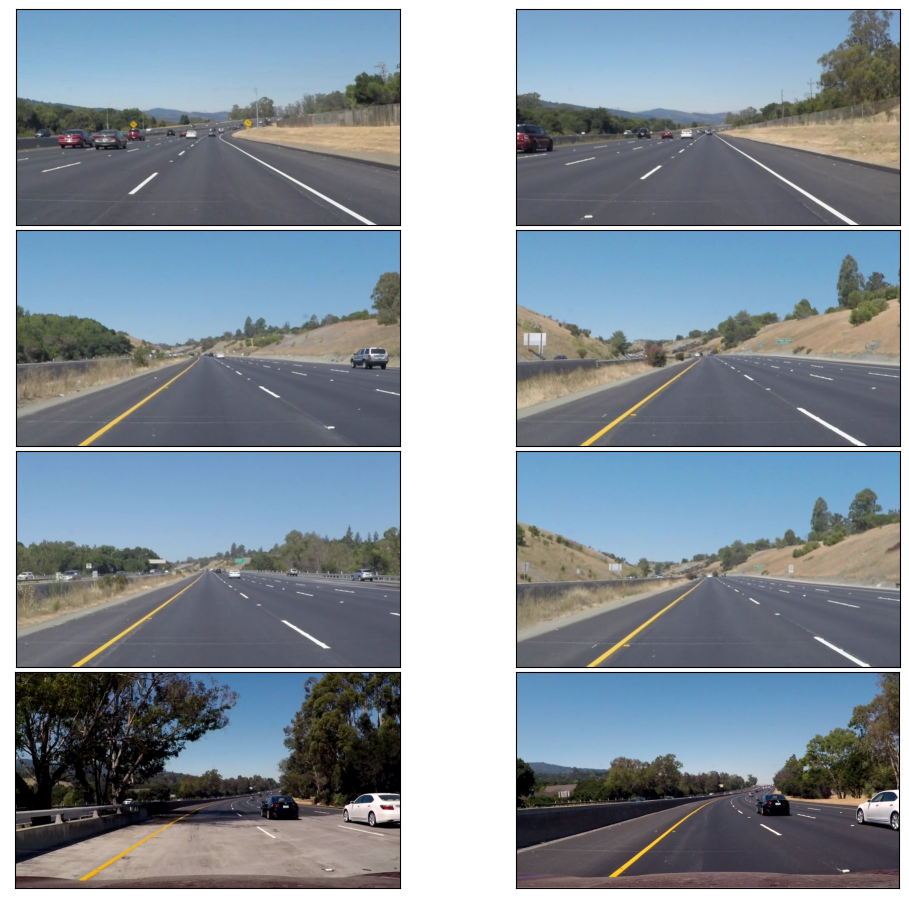

In [12]:
# test images
test_images = [plt.imread(img) for img in glob.glob('test_images/*.jpg')]
list_images(test_images)

In [13]:
# Based on RGB color section (white and yellow lines)
def RGB_color_selection(image):
    lower_threshold = np.uint8([200, 200, 200])
    upper_threshold = np.uint8([255, 255, 255])
    white_mask = cv2.inRange(image, lower_threshold, upper_threshold)
    
    lower_threshold = np.uint8([175, 175,   0])
    upper_threshold = np.uint8([255, 255, 255])
    yellow_mask = cv2.inRange(image, lower_threshold, upper_threshold)
    
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    masked_image = cv2.bitwise_and(image, image, mask = mask)
    
    return masked_image

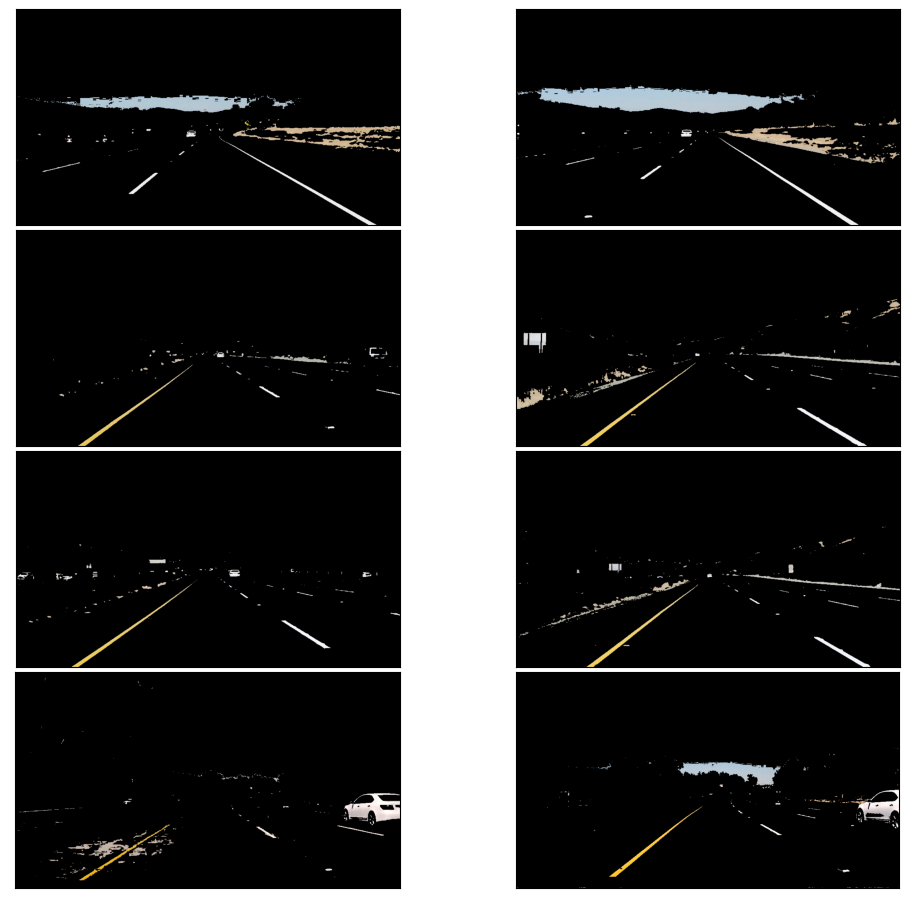

In [14]:
list_images(list(map(RGB_color_selection, test_images)))

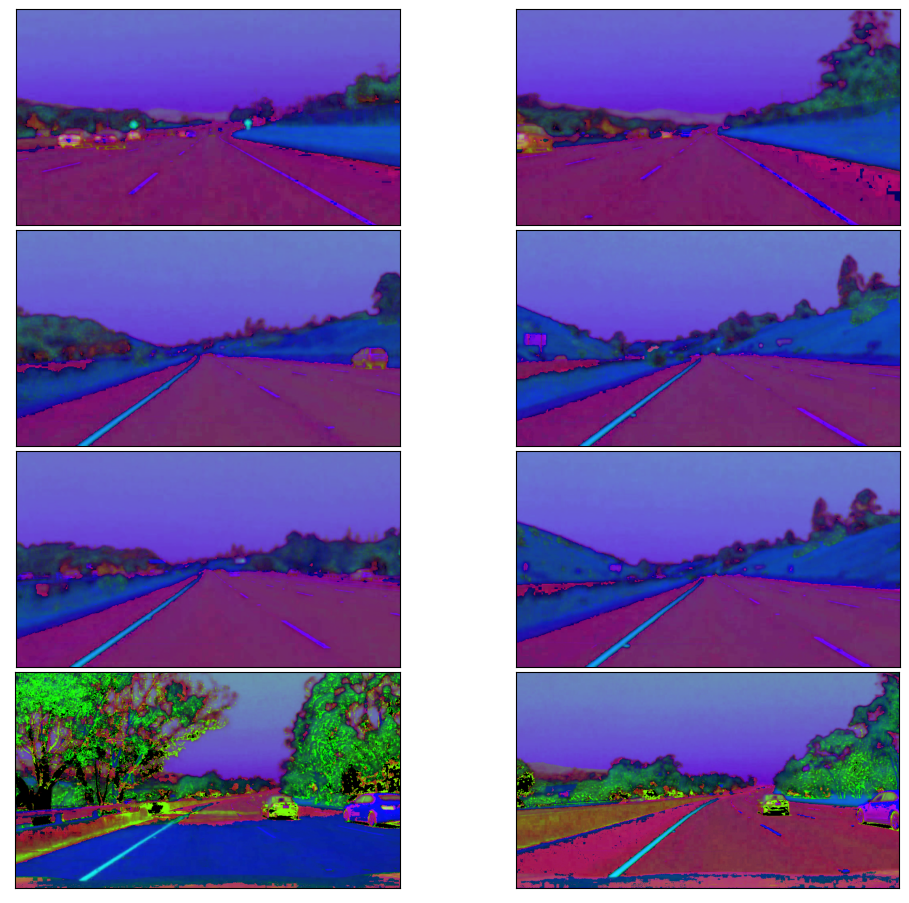

In [15]:
# convering rgb to hsv
def convert_hsv(image):

    return cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

list_images(list(map(convert_hsv, test_images)))

In [16]:
# color selection using hsv
def HSV_color_selection(image):
    converted_image = convert_hsv(image)
    
    lower_threshold = np.uint8([0, 0, 210])
    upper_threshold = np.uint8([255, 30, 255])
    white_mask = cv2.inRange(converted_image, lower_threshold, upper_threshold)
    
    lower_threshold = np.uint8([18, 80, 80])
    upper_threshold = np.uint8([30, 255, 255])
    yellow_mask = cv2.inRange(converted_image, lower_threshold, upper_threshold)
    
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    masked_image = cv2.bitwise_and(image, image, mask = mask)
    
    return masked_image

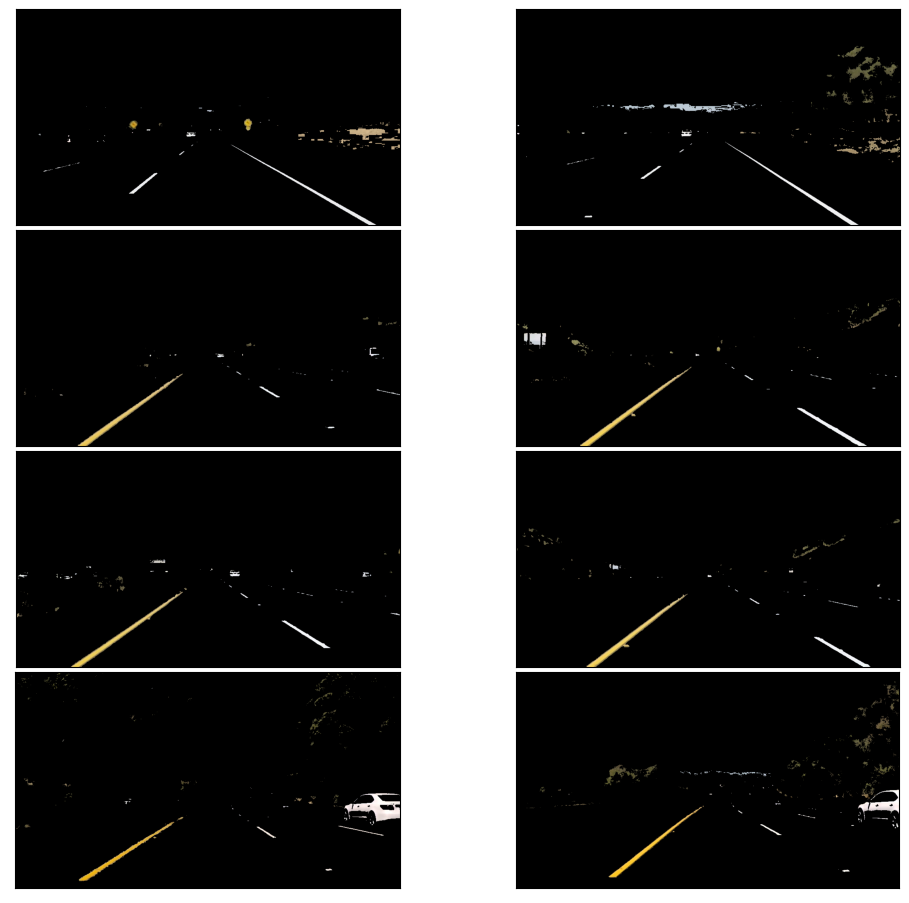

In [17]:
list_images(list(map(HSV_color_selection, test_images)))

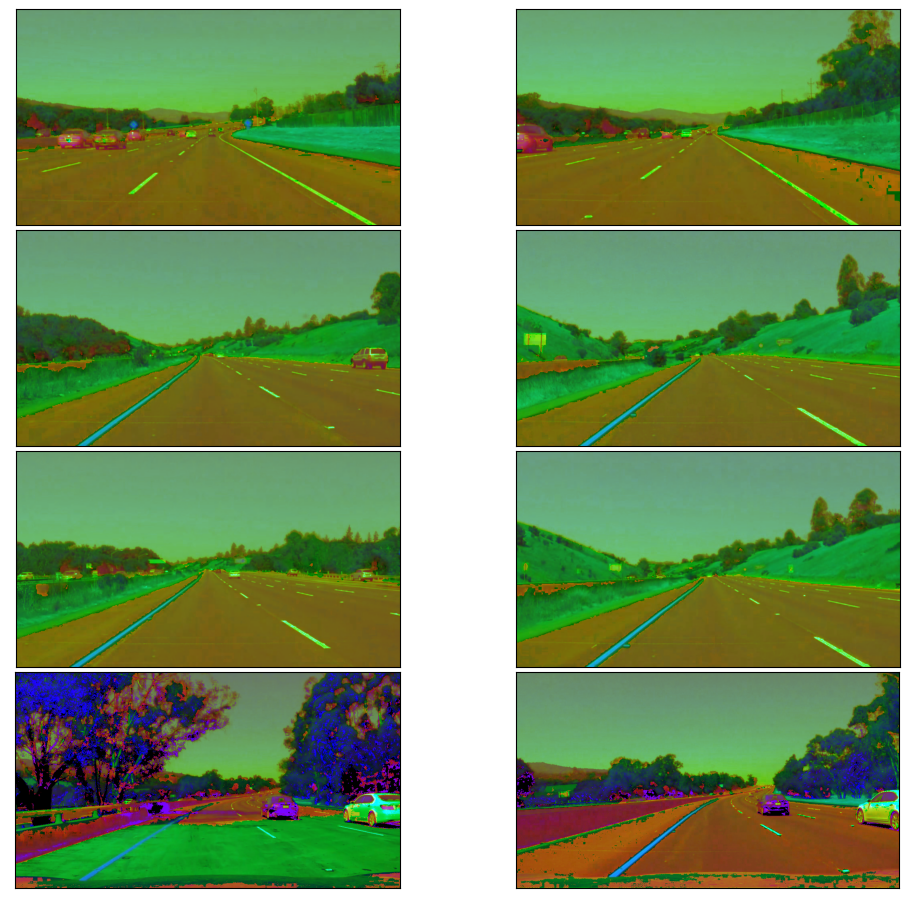

In [18]:
def convert_hsl(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2HLS)

list_images(list(map(convert_hsl, test_images)))

In [19]:
def HSL_color_selection(image):
    converted_image = convert_hsl(image)
    
    lower_threshold = np.uint8([0, 200, 0])
    upper_threshold = np.uint8([255, 255, 255])
    white_mask = cv2.inRange(converted_image, lower_threshold, upper_threshold)
    
    lower_threshold = np.uint8([10, 0, 100])
    upper_threshold = np.uint8([40, 255, 255])
    yellow_mask = cv2.inRange(converted_image, lower_threshold, upper_threshold)
    
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    masked_image = cv2.bitwise_and(image, image, mask = mask)
    
    return masked_image

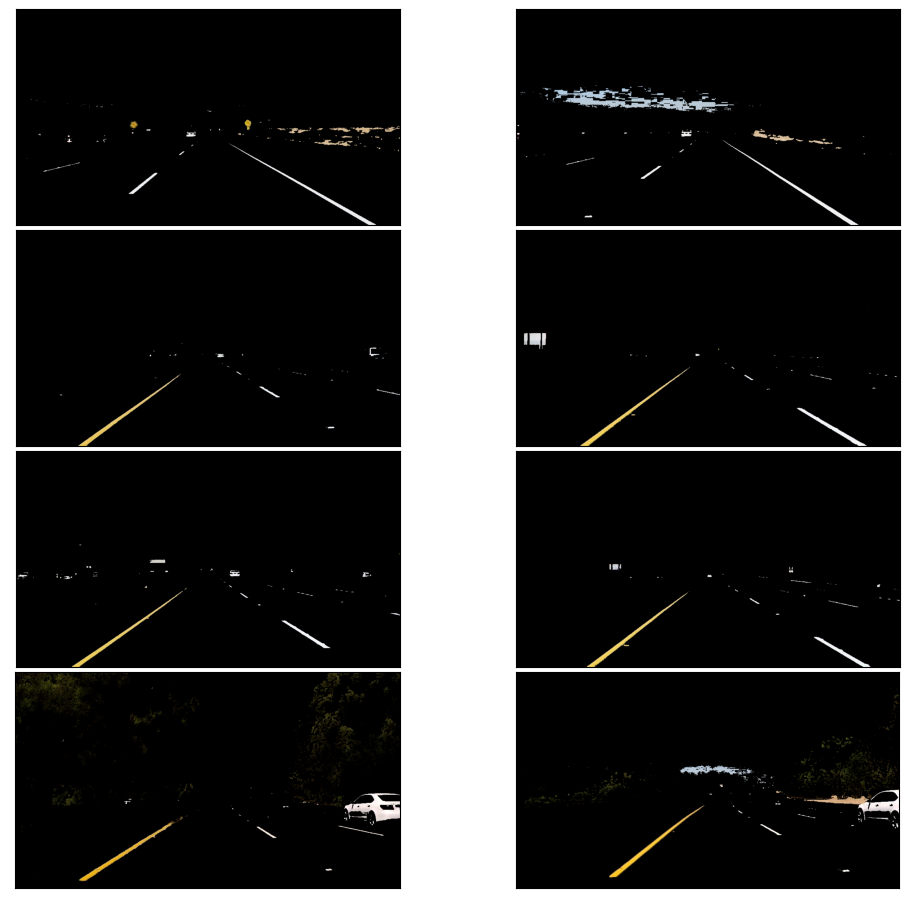

In [20]:
list_images(list(map(HSL_color_selection, test_images)))

In [21]:
color_selected_images = list(map(HSL_color_selection, test_images))

In [22]:
# Image to grey scale image
def gray_scale(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

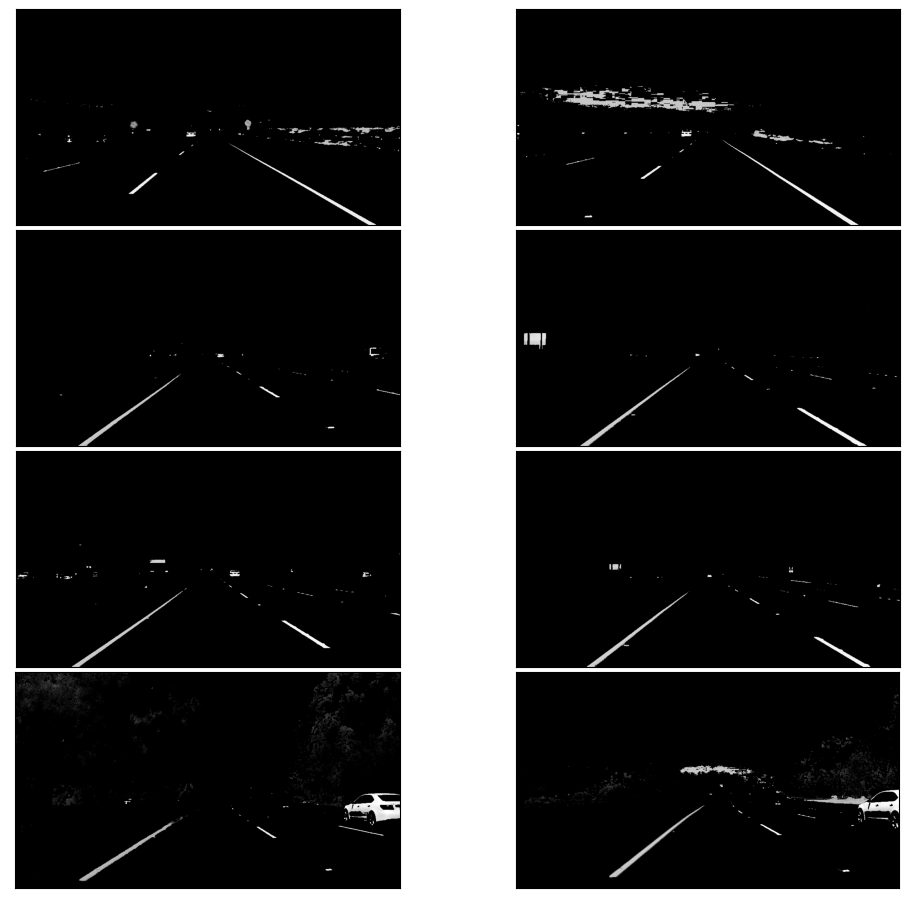

In [23]:
gray_images = list(map(gray_scale, color_selected_images))
list_images(gray_images)

In [24]:
# Smoothing of image
def gaussian_smoothing(image, kernel_size = 13):
    return cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)   

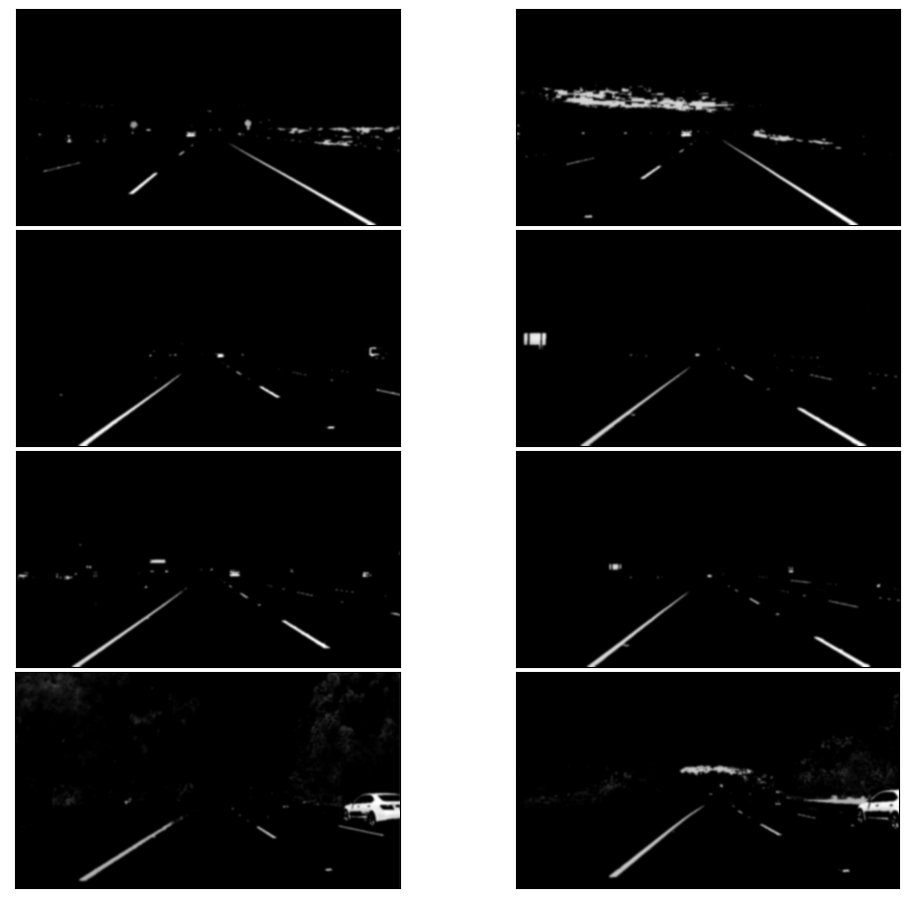

In [25]:
blur_images = list(map(gaussian_smoothing, gray_images))
list_images(blur_images)

In [26]:
# Using canny edge detection to detect edges of road
def canny_detector(image, low_threshold = 50, high_threshold = 150):
    return cv2.Canny(image, low_threshold, high_threshold)

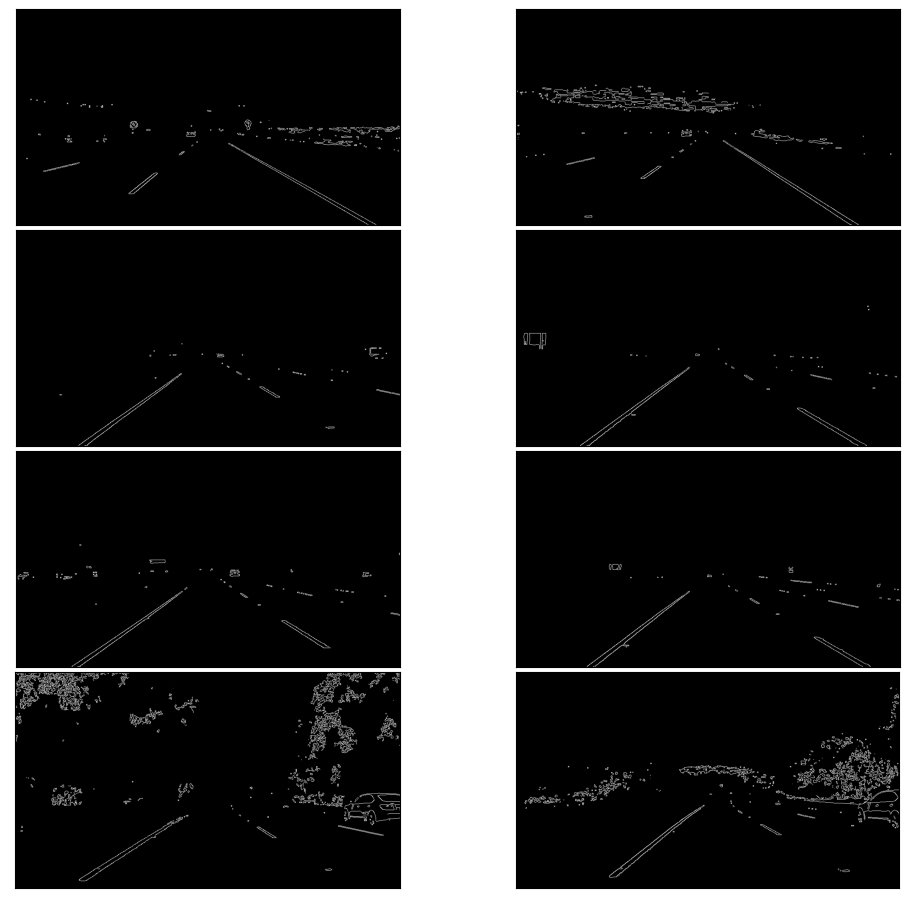

In [27]:
edge_detected_images = list(map(canny_detector, gray_images))
list_images(edge_detected_images)

In [28]:
# Masking reagion of interest
def region_selection(image):
    mask = np.zeros_like(image)   
    if len(image.shape) > 2:
        channel_count = image.shape[2]
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
    rows, cols = image.shape[:2]
    bottom_left  = [cols * 0.1, rows * 0.95]
    top_left     = [cols * 0.4, rows * 0.6]
    bottom_right = [cols * 0.9, rows * 0.95]
    top_right    = [cols * 0.6, rows * 0.6]
    vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_image = cv2.bitwise_and(image, mask)
    return masked_image

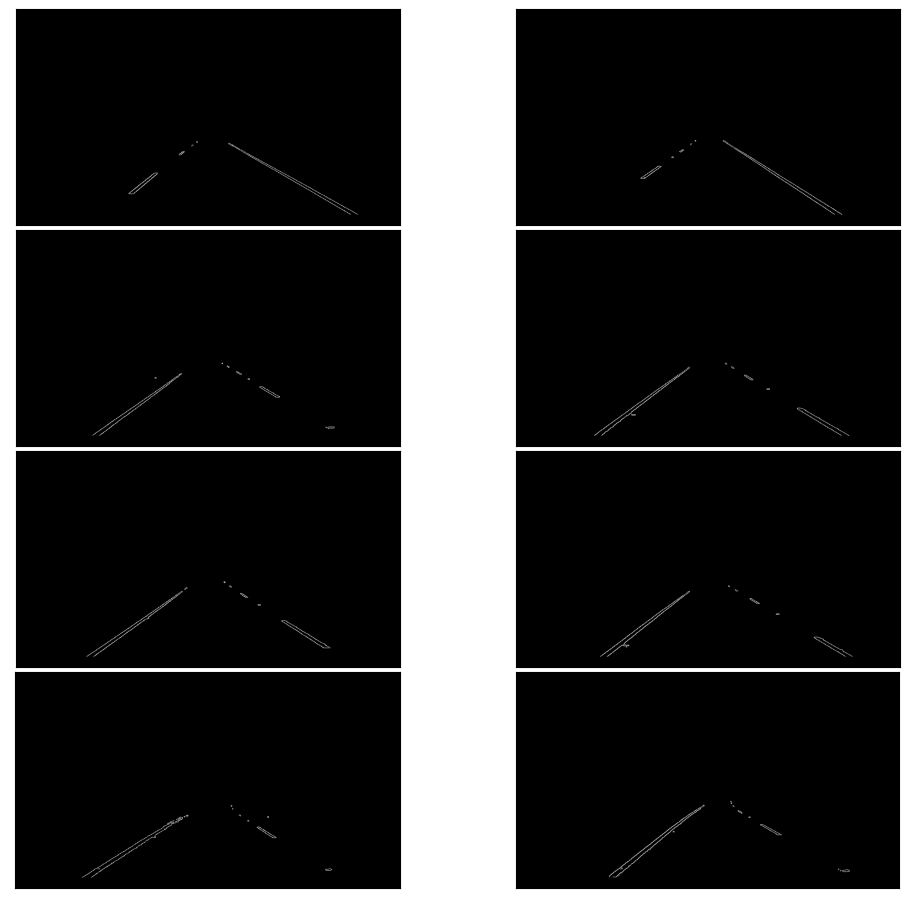

In [29]:
masked_image = list(map(region_selection, edge_detected_images))
list_images(masked_image)

In [30]:
# import imutils
# masked_image[6] = imutils.rotate(masked_image[6], angle=15)
# test_images[6] = imutils.rotate(test_images[6], angle=15)

In [31]:
# Mapping lines using haugh transform
def hough_transform(image):
    rho = 1
    theta = np.pi/180
    threshold = 30
    minLineLength = 50
    maxLineGap = 300
    return cv2.HoughLinesP(image, rho = rho, theta = theta, threshold = threshold,
                           minLineLength = minLineLength, maxLineGap = maxLineGap)

In [32]:
hough_lines = list(map(hough_transform, masked_image))

In [33]:
# img = masked_image[7]

In [34]:
# list_images([img])

In [35]:
# Drawing lines on the image
def draw_lines(image, lines, color = [255, 0, 0], thickness = 2):
    image = np.copy(image)
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(image, (x1, y1), (x2, y2), color, thickness)
    return image

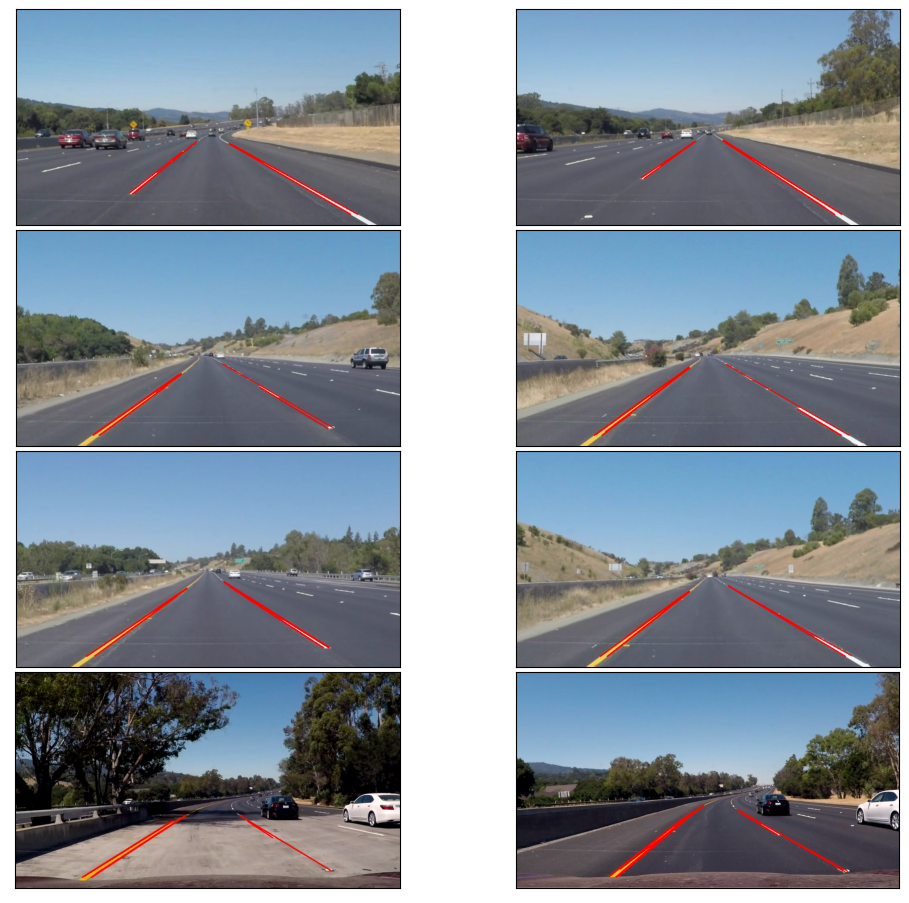

In [36]:
line_images = []
for image, lines in zip(test_images, hough_lines):
    line_images.append(draw_lines(image, lines))
    
list_images(line_images)

In [37]:
def map_coordinates(frame, parameters):
    
    height, width, _ = frame.shape
    slope, intercept = parameters
    
    if slope == 0:
        slope = 0.1
    
    y1 = height
    y2 = int(height*0.6)
    x1 = int((y1 - intercept) / slope)
    x2 = int((y2 - intercept) / slope)
    return [[x1, y1, x2, y2]]

In [38]:
# Otimizing the line by joining and streaching them
def optimize_lines(frame, lines):
    height, width, _ = frame.shape
    
    if lines is not None:
        lane_lines = []
        left_fit = []
        right_fit = []        
        for line in lines:
            x1, y1, x2, y2 = line.reshape(4)

            parameters = np.polyfit((x1, x2), (y1, y2), 1)
            slope = parameters[0]
            intercept = parameters[1]
            
            if slope < 0:
                left_fit.append((slope, intercept))
            else:   
                right_fit.append((slope, intercept))

        if len(left_fit) > 0:
            left_fit_average = np.average(left_fit, axis=0)
            lane_lines.append(map_coordinates(frame, left_fit_average))
            
        if len(right_fit) > 0:
            right_fit_average = np.average(right_fit, axis=0)
            lane_lines.append(map_coordinates(frame, right_fit_average))
        
    return lane_lines

In [39]:
opt_lines = []
for image, lines in zip(test_images, hough_lines):
    opt_lines.append(optimize_lines(image, lines))

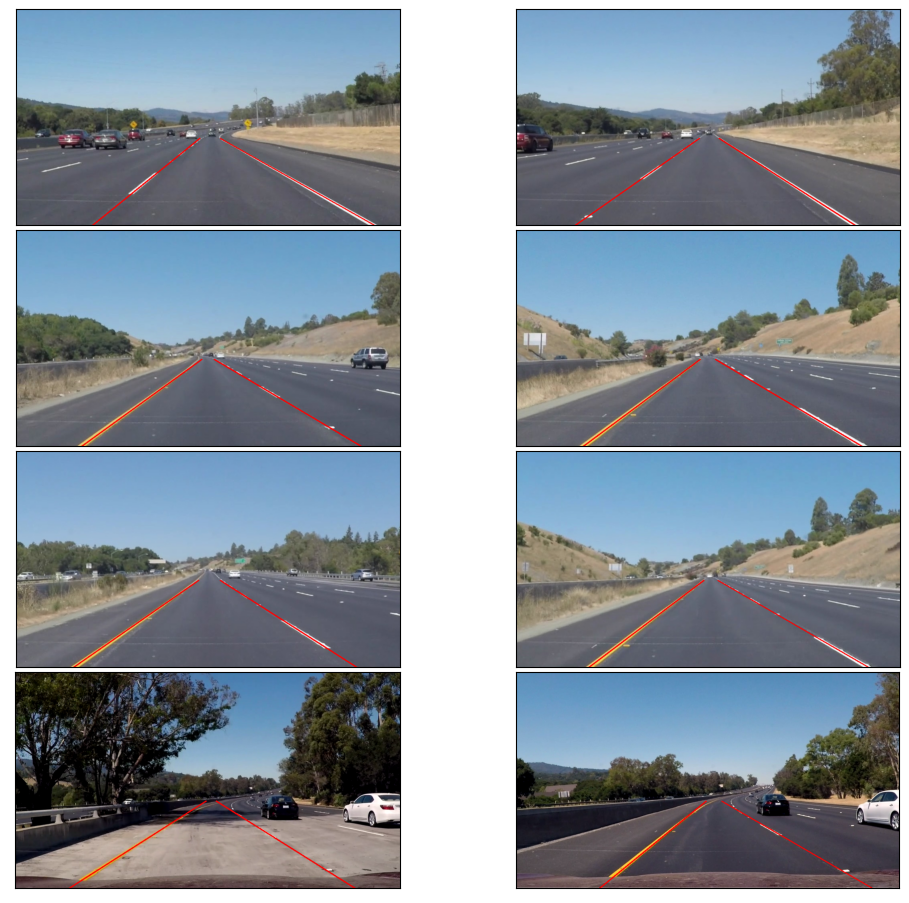

In [40]:
line_images = []
for image, lines in zip(test_images, opt_lines):
    line_images.append(draw_lines(image, lines))
    
list_images(line_images)

In [41]:
# Center of lines on the image
def get_floating_center(frame, lane_lines):
    
    height, width, _ = frame.shape
    
    if len(lane_lines) == 2:
        left_x1, _, left_x2, _ = lane_lines[0][0]
        right_x1, _, right_x2, _ = lane_lines[1][0]
        
        low_mid = (right_x1 + left_x1) / 2
        up_mid = (right_x2 + left_x2) / 2

    else:
        up_mid = int(width*1.9)
        low_mid = int(width*1.9)
    
    return up_mid, low_mid

In [42]:
# Getting the deviation by comparing the center point of actual line and the detected lines in the projection (based on the distribution of white lines)
def add_text(frame, image_center, left_x_base, right_x_base):

    lane_center = left_x_base + (right_x_base - left_x_base) / 2
    
    deviation = image_center - lane_center

    print(deviation)
    if deviation > 160:
        text = "Left"
    elif deviation >= 20 and deviation <= 150:
        text = "Straight"
    elif deviation < 20:
        text = "Right"
    
    cv2.putText(frame, "Final: " + text, (50, 50), cv2.FONT_HERSHEY_DUPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
    
    return frame

In [61]:
# Generating the histogram to measure the lane lines
def histogram(frame):
    
    histogram = np.sum(frame, axis=0)   
    midpoint = np.int(histogram.shape[0]/2)    
    
    left_x_base = np.argmax(histogram[:midpoint])
    
    right_x_base = np.argmax(histogram[midpoint:]) + midpoint
    
    return left_x_base, right_x_base

In [62]:
# Calculating the region of interest for getting the lines
# def op():
#     height, width = image.shape[:2]
#     source_points = np.float32([[int(width*0.4), int(height*0.6)],
#                       [int(width*0.6), int(height*0.6)],
#                       [int(width*0.1), height*0.95],
#                       [int(width*0.9), height*0.95]])
#     print(source_points)
# op()

In [63]:
# Changing the prespective of the region of interst got get the top view
def warp_perspective(frame):
    height, width = image.shape[:2]
    
    offset = 50    
    source_points = np.float32([[int(width*0.45), int(height*0.6)],
                      [int(width*0.55), int(height*0.6)],
                      [int(width*0.1), height*0.95],
                      [int(width*0.9), height*0.95]])
    
    destination_points = np.float32([[offset, 0],
                      [width-2*offset, 0],
                      [offset, height],
                      [width-2*offset, height]])
    
    matrix = cv2.getPerspectiveTransform(source_points, destination_points) 
    
    skyview = cv2.warpPerspective(frame, matrix, (width, height))    

    return skyview

In [64]:
# len(test_images), len(opt_lines), len(line_images), len(masked_image)

56.5
21.0
66.5
44.0
30.5
22.5
8.5
-33.5


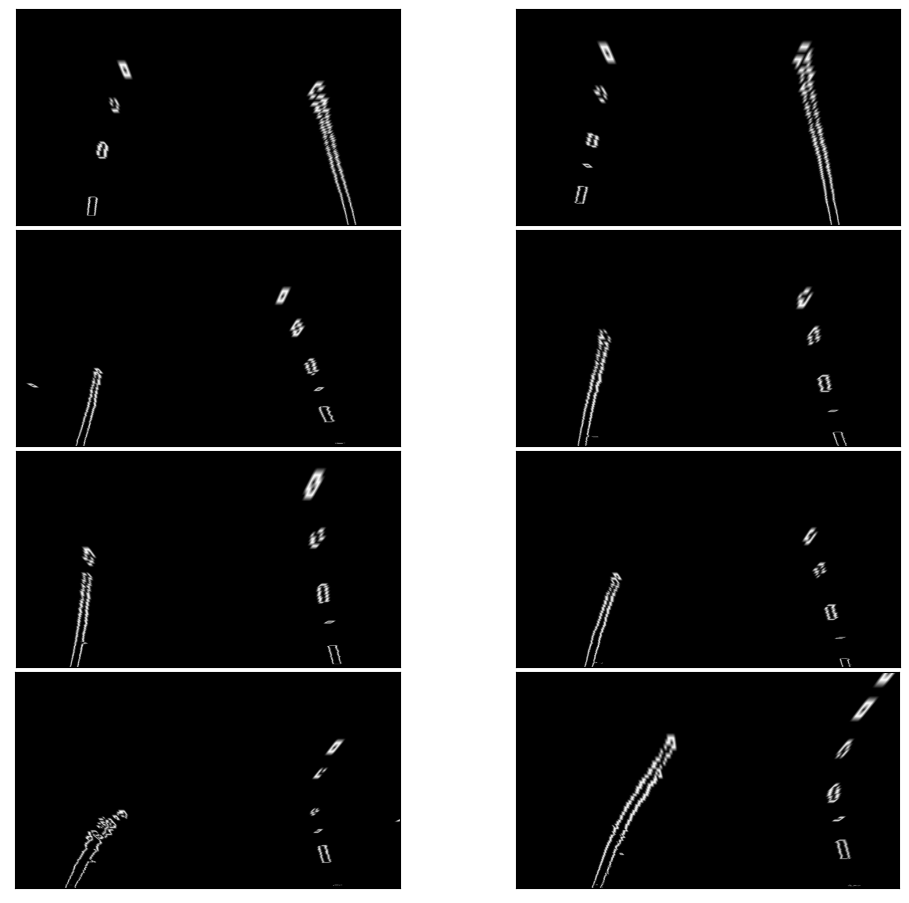

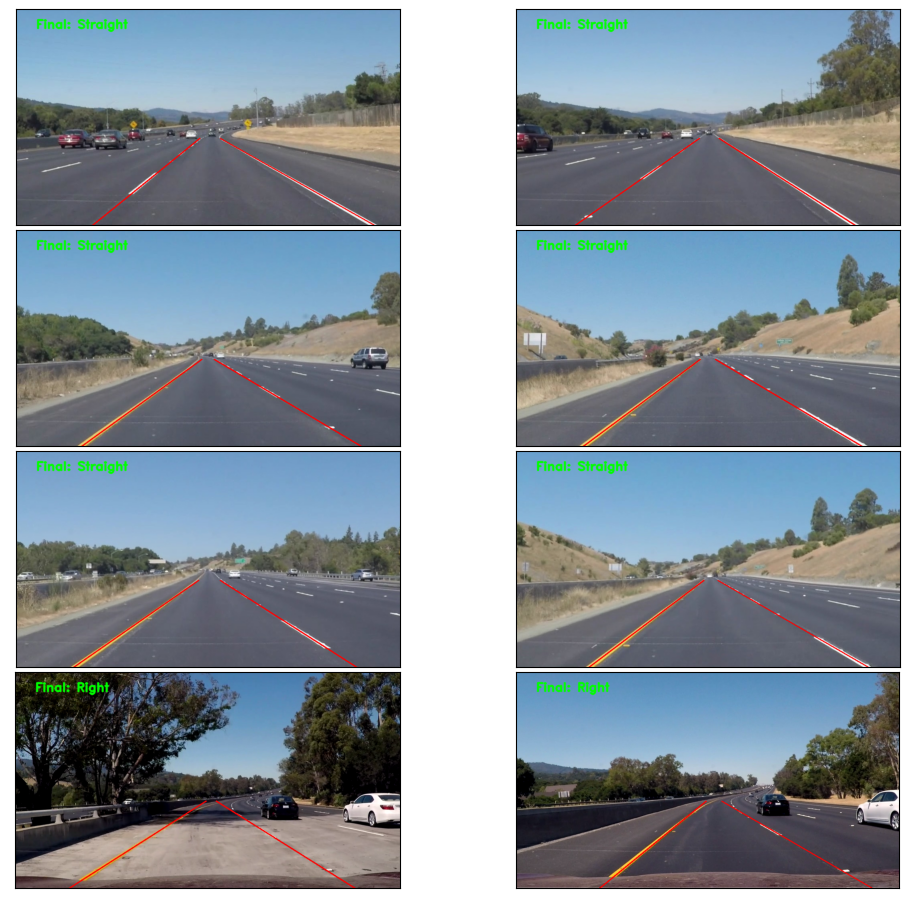

In [65]:
istemp = []
temp = []
for image, lines, op_frame, mi in zip(test_images, opt_lines, line_images, masked_image):
  im = warp_perspective(mi)
  istemp.append(im)
  left_x_base, right_x_base = histogram(im)
  _, low_center = get_floating_center(image, lines)
  final_frame = add_text(op_frame, low_center, left_x_base, right_x_base)
  temp.append(final_frame)
list_images(istemp)
list_images(temp)

In [119]:
def process_video(frame):
    pass